In [1]:
# Multiplicative scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m
n_u   = 1e-3
u_n   = 1/n_u

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series #.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [3]:
pip install pyyaml

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import yaml
import pandas as pd
from pandas import json_normalize

# Load YAML
with open("cpu_sim.yaml", "r") as f:
    data = yaml.safe_load(f)

# Flatten into a DataFrame
prmtrs_df = json_normalize(data, sep=".")
print(prmtrs_df.T)  # transpose to make it easier to read

prm_cmp_ltnc_nS_B   = float(prmtrs_df['cmp_ltnc_nS_B'].iloc[0])
prm_output_size_GB  = float(prmtrs_df['output_size_GB'].iloc[0])
prm_nic_Gbps        = float(prmtrs_df['nic_Gbps'].iloc[0])
prm_daq_frm_sz_MB     = float(prmtrs_df['frame_sz_MB'].iloc[0])
prm_frame_cnt       = int(prmtrs_df['frame_cnt'].iloc[0])
prm_cmpnt_cnt       = int(prmtrs_df['cmpnt_cnt'].iloc[0])
prm_avg_bit_rt_Gbps = float(prmtrs_df['avg_bit_rt_Gbps'].iloc[0])

                         0
cmp_ltnc_nS_B    500.00000
output_size_GB     0.00006
nic_Gbps         100.00000
frame_sz_MB        0.06000
frame_cnt        100.00000
cmpnt_cnt          6.00000
avg_bit_rt_Gbps    0.01000


In [5]:
prmtrs_df

cmp_ltnc_nS_B  output_size_GB  nic_Gbps  frame_sz_MB  frame_cnt  cmpnt_cnt  \
0            500         0.00006       100         0.06        100          6   

   avg_bit_rt_Gbps  
0             0.01

In [6]:
print(prm_cmp_ltnc_nS_B,prm_output_size_GB,prm_nic_Gbps,prm_daq_frm_sz_MB,prm_frame_cnt,prm_cmpnt_cnt,prm_avg_bit_rt_Gbps)

500.0 6e-05 100.0 0.06 100 6 0.01


In [7]:
#rng = np.random.default_rng(random_state) # random init
rng = np.random.default_rng(7) # repeatable init

In [8]:
import numpy as np

def gamma_samples(mean, stdev, n_samples, rng):
    """
    Generate n_samples from a Gamma distribution with given mean and stdev.
    
    Parameters:
        mean (float): Desired mean of the distribution
        stdev (float): Desired standard deviation
        n_samples (int): Number of samples to generate
        random_state (int, optional): Random seed for reproducibility
    
    Returns:
        numpy.ndarray: Array of gamma-distributed samples
    """
    
    # Derive shape (k) and scale (theta)
    shape = (mean / stdev) ** 2
    scale = (stdev ** 2) / mean
    
    return rng.gamma(shape, scale, n_samples)


Empirical mean: 424.7663263588696
Empirical std: 42.3286984452394


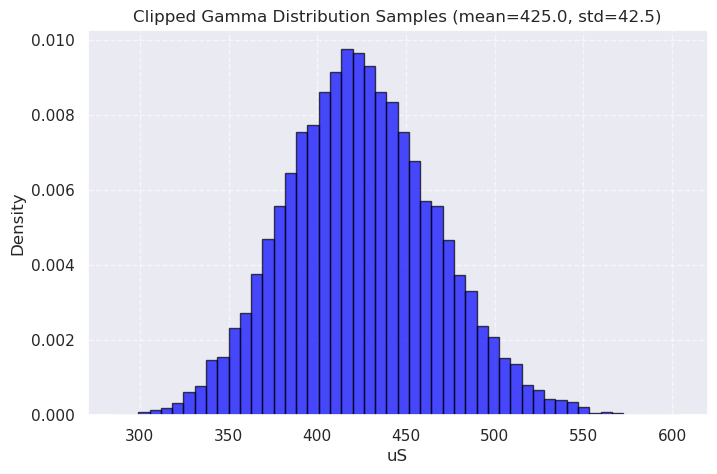

In [9]:
# Clipped Network Latency Samples
import numpy as np
import matplotlib.pyplot as plt

# Target mean and std
cnst_ntwrk_lt_mean_uS = 0.425*m_u  #float(one_u*M_1*prm_daq_frm_sz_MB/(b_B*G_1*prm_nic_Gbps))
cnst_ntwrk_lt_sd_uS = cnst_ntwrk_lt_mean_uS/10

# Bound samples to lower bound
cnst_nl_smpls_uS = gamma_samples(cnst_ntwrk_lt_mean_uS, cnst_ntwrk_lt_sd_uS, int(1e4), rng)

# Verification
print("Empirical mean:", np.mean(cnst_nl_smpls_uS))
print("Empirical std:",  np.std(cnst_nl_smpls_uS))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(cnst_nl_smpls_uS, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Clipped Gamma Distribution Samples (mean={cnst_ntwrk_lt_mean_uS}, std={cnst_ntwrk_lt_sd_uS})")
plt.xlabel("uS")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Empirical mean: 459.55114273080255
Empirical std: 26.729869967199235


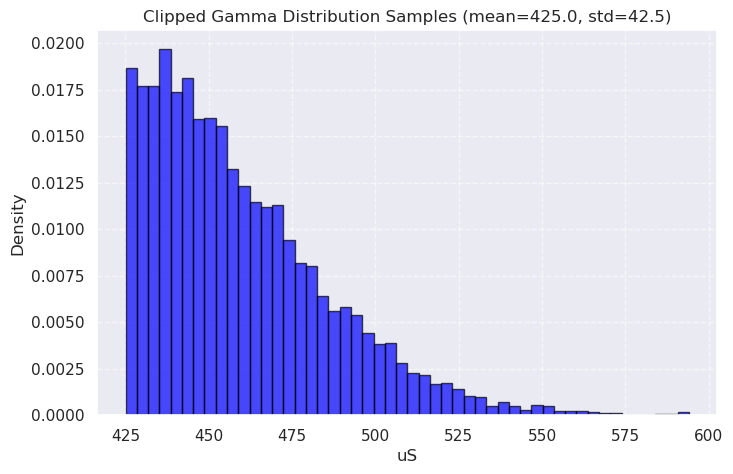

In [10]:
# Sample until > mean Network Latency Samples
import numpy as np
import matplotlib.pyplot as plt
import math

# Target mean and std
cnst_ntwrk_lt_mean_uS = 0.425*m_u  #float(one_u*M_1*prm_daq_frm_sz_MB/(b_B*G_1*prm_nic_Gbps))
cnst_ntwrk_lt_sd_uS = cnst_ntwrk_lt_mean_uS/10

# Sample from Gamma
raw_samples = gamma_samples(cnst_ntwrk_lt_mean_uS, cnst_ntwrk_lt_sd_uS, int(1e4), rng)
# Bound samples to lower bound
cnst_nl_smpls_uS = raw_samples[raw_samples >= cnst_ntwrk_lt_mean_uS]

# Verification
print("Empirical mean:", np.mean(cnst_nl_smpls_uS))
print("Empirical std:",  np.std(cnst_nl_smpls_uS))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(cnst_nl_smpls_uS, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Clipped Gamma Distribution Samples (mean={cnst_ntwrk_lt_mean_uS}, std={cnst_ntwrk_lt_sd_uS})")
plt.xlabel("uS")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Empirical mean: 60025.16975960197
Empirical std: 6020.044123558148


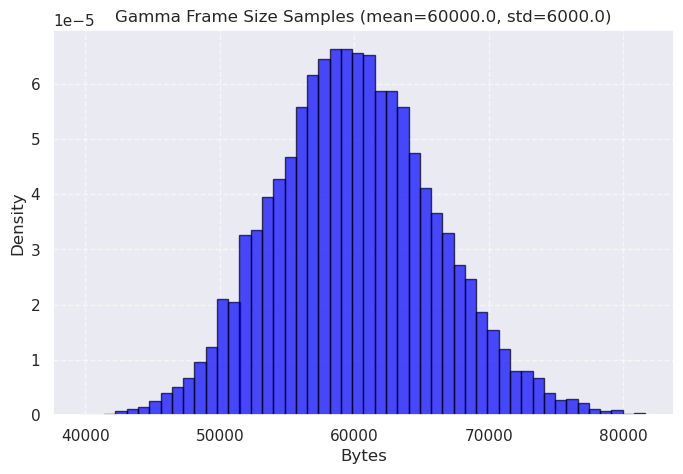

In [11]:
# Frame Size Samples
import numpy as np
import matplotlib.pyplot as plt

cnst_daq_fs_mean_B = float(M_1*prm_daq_frm_sz_MB)
# Target mean and std
cnst_fs_std_B = 0.1*cnst_daq_fs_mean_B

# Sample from Gamma
cnst_fs_smpls_B = gamma_samples(cnst_daq_fs_mean_B, cnst_fs_std_B, int(1e4), rng)

# Verification
print("Empirical mean:", np.mean(cnst_fs_smpls_B))
print("Empirical std:",  np.std(cnst_fs_smpls_B))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(cnst_fs_smpls_B, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Gamma Frame Size Samples (mean={cnst_daq_fs_mean_B}, std={cnst_fs_std_B})")
plt.xlabel("Bytes")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Empirical mean: 60057.658825117804
Empirical std: 5995.602065633223


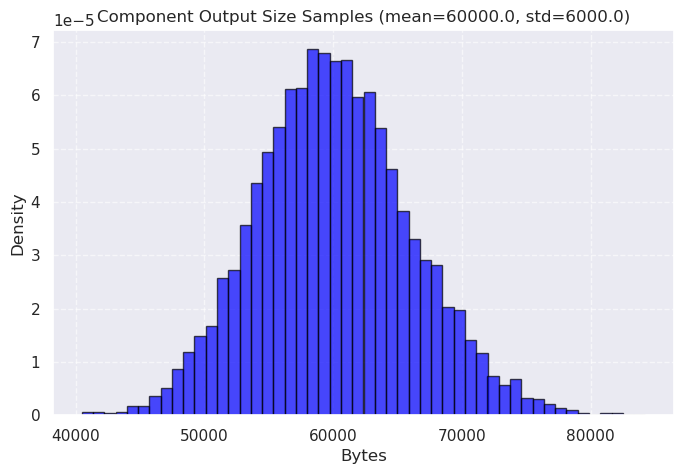

In [12]:
# Out Size Samples
import numpy as np
import matplotlib.pyplot as plt

cnst_os_mean_B = float(G_1*prm_output_size_GB)
# Target mean and std
cnst_os_std_B = 0.1*cnst_os_mean_B

# Sample from Gamma
os_smpls_B = gamma_samples(cnst_os_mean_B, cnst_os_std_B, int(1e4), rng)

# Verification
print("Empirical mean:", np.mean(os_smpls_B))
print("Empirical std:",  np.std(os_smpls_B))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(os_smpls_B, bins=50, density=True, alpha=0.7, color="blue", edgecolor="black")
plt.title(f"Component Output Size Samples (mean={cnst_os_mean_B}, std={cnst_os_std_B})")
plt.xlabel("Bytes")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [13]:
#Frames actually processed by components
import math

prcsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "cmp_ltnc_uS": pd.Series(dtype=float),
    "ntwrk_lt_uS": pd.Series(dtype=float),
    "snt_uS":      pd.Series(dtype=float),
    "done_uS":     pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Frames that components were not ready to receive
drpmsdFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "rcd_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float),
    "lstDone_uS":  pd.Series(dtype=float)
}) # contains no dropped/missed frames

#Data on all sent frames - component 0 is source
sentFrms_df = pd.DataFrame({
    "component":   pd.Series(dtype=int),
    "snt_uS":      pd.Series(dtype=float),
    "frm_nm":      pd.Series(dtype=int),
    "frm_sz_b":    pd.Series(dtype=float)
}) 

#set of all frame numbers from sender
cnst_all_frm_set = set(range(1, prm_frame_cnt + 1))   # range is exclusive at the end, so add 1 for inclusive

# component 0 is the sender
clk_uS      = zeros = np.zeros(prm_cmpnt_cnt+1, dtype=float) #Time last frame finished processing

vrbs = True

cnst_swtch_lt_uS = 1 #switch latency

lf = open("output.txt", "w")

#Simulation
for f in range(0, prm_frame_cnt):
    # impulse
#    if f==prm_frame_cnt/2: prm_nic_Gbps /= 2 #######################################
#    if f==prm_frame_cnt/2: prm_cmp_ltnc_nS_B *= 2 #######################################
    cnst_daq_frm_sz0_b = B_b*cnst_daq_fs_mean_B; #cnst_fs_smpls_B[f]
    if vrbs: print(f"{clk_uS[0]} Send frame {f} Size: {cnst_daq_frm_sz0_b:10.2f}", file=lf)
    #component zero is the sender
    row = (0,clk_uS[0],f,cnst_daq_frm_sz0_b)
    sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)
    for c in range(1, prm_cmpnt_cnt+1):
        #set component forwarding frame size to component output Size
        frm_szc_b = B_b*os_smpls_B[f*prm_cmpnt_cnt+c]
        clk_c = clk_uS[c-1] #temp clk base = upstream senders 'done/sent' value
        # set recvd frame size: cmpnt #1 is senders size, all others are cmpnt output size
        # it is assumed that the sender represents a DAQ with fixed frame size
        # inducing (highly)? variable computational lateny
        if c == 1:
            frm_sz_b = cnst_daq_frm_sz0_b
        else:
            frm_sz_b = B_b*os_smpls_B[f*prm_cmpnt_cnt+c-1]

        # component receives with network latency offset from upstream sender time
        cnst_ntwrk_lt_mean_uS = float(one_u*frm_sz_b/(G_1*prm_nic_Gbps))
        cnst_ntwrk_lt_sd_uS = math.ceil(cnst_ntwrk_lt_mean_uS/20) #5%
        ntwrk_lt_uS = 0
        while ntwrk_lt_uS < cnst_ntwrk_lt_mean_uS: #enforce lower bound
            ntwrk_lt_uS = gamma_samples(cnst_ntwrk_lt_mean_uS, cnst_ntwrk_lt_sd_uS, int(1), rng)[0]

        ntwrk_lt_uS += cnst_swtch_lt_uS  #add switch latency
        clk_c += ntwrk_lt_uS  #Update temp clk for net latency
        rcd_uS = clk_c #Time would recv from upstream sender if ready
        if vrbs: print(f"{clk_c} Component {c} Recv Frame {f} Size: {frm_sz_b:10.2f}", file=lf)
        if (clk_uS[c] > clk_c): # True -> not ready to recv
            if vrbs: print(f"{clk_c} Component {c} Missed Frame {f}", file=lf)
            row = (c,rcd_uS,f,frm_sz_b,clk_uS[c])
            drpmsdFrms_df = pd.concat([drpmsdFrms_df, pd.DataFrame([row], columns=drpmsdFrms_df.columns)], ignore_index=True)
            break; #If temp clk > components last 'done' time, frame is missed for this and all downstream components
        # component processes with compute latency
        cmp_ltnc_nS_B = gamma_samples(prm_cmp_ltnc_nS_B, prm_cmp_ltnc_nS_B/10, int(1), rng)[0]
        cmp_ltnc_uS = float(n_u*cmp_ltnc_nS_B*frm_sz_b*b_B)
        clk_c += cmp_ltnc_uS #Update temp clk for compute latency
        clk_c += 10 #add overhead
        snt_uS = clk_c
        row = (c,snt_uS,f,frm_szc_b)
        sentFrms_df = pd.concat([sentFrms_df, pd.DataFrame([row], columns=sentFrms_df.columns)], ignore_index=True)
        clk_c += 10 #add overhead
        clk_uS[c]  = clk_c #Set as last 'done' time
        if vrbs and c == prm_cmpnt_cnt: print(f"Update sim clock to {clk_c} for component {c}", file=lf)
        if vrbs: print(f"{clk_c} Component {c} Done Frame {f} Size: {frm_sz_b:10.2f}", file=lf)
        #add prcsdFrms_df row
        row = (c,rcd_uS,f,frm_sz_b,cmp_ltnc_uS,ntwrk_lt_uS,snt_uS,clk_uS[c])
        prcsdFrms_df = pd.concat([prcsdFrms_df, pd.DataFrame([row], columns=prcsdFrms_df.columns)], ignore_index=True)
    # Sender Rate Sleep
    rtSlp_uS   = float(one_u*cnst_daq_frm_sz0_b / (G_1*prm_avg_bit_rt_Gbps))
    clk_uS[0] += rtSlp_uS

lf.close()   # must close manually    

In [14]:
def moving_average(a, n=5):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n

Component 0 Send Delta Statistics:
count: 99.000
mean: 10.000
std: 0.000
skew: nan
kurtosis: nan


/scratch/slurm/54656616/.cache/tmp/ipykernel_1464477/647169241.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(values),
/scratch/slurm/54656616/.cache/tmp/ipykernel_1464477/647169241.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(values)


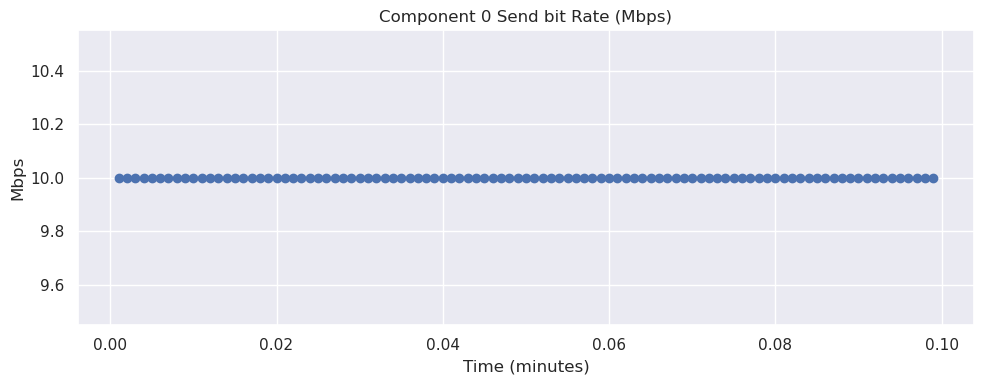

Component 1 Send Delta Statistics:
count: 99.000
mean: 10.192
std: 1.256
skew: 0.065
kurtosis: -0.700


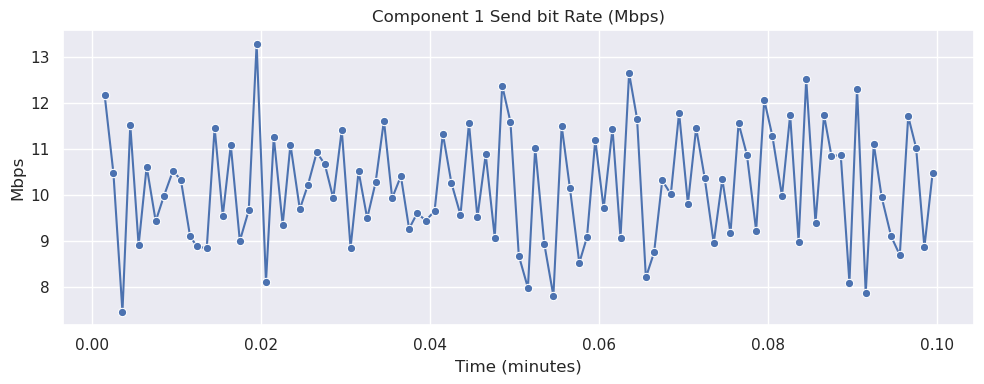

Component 2 Send Delta Statistics:
count: 99.000
mean: 9.942
std: 1.677
skew: 0.983
kurtosis: 1.222


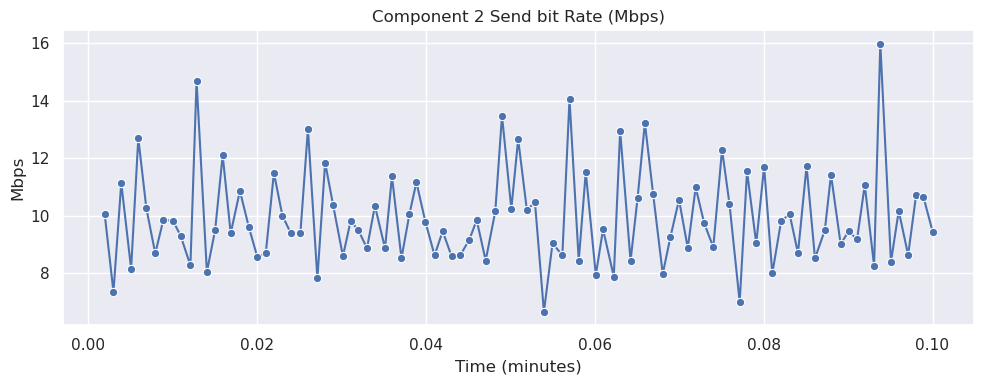

Component 3 Send Delta Statistics:
count: 99.000
mean: 10.208
std: 1.899
skew: 0.479
kurtosis: -0.169


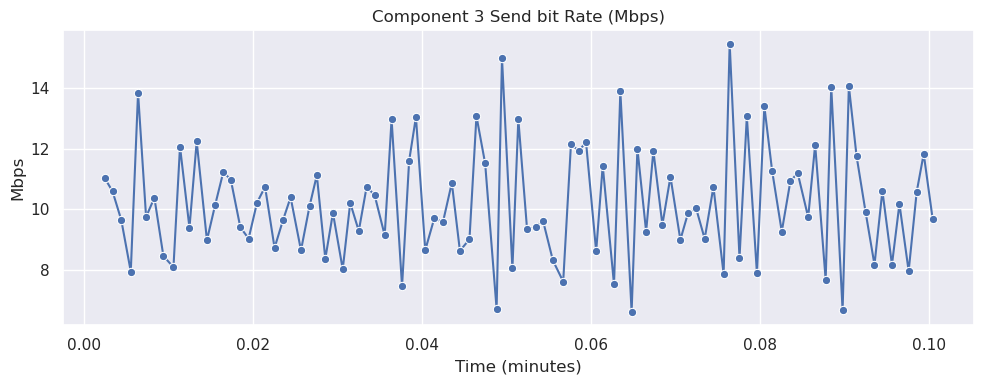

Component 4 Send Delta Statistics:
count: 99.000
mean: 10.444
std: 2.232
skew: 0.589
kurtosis: -0.157


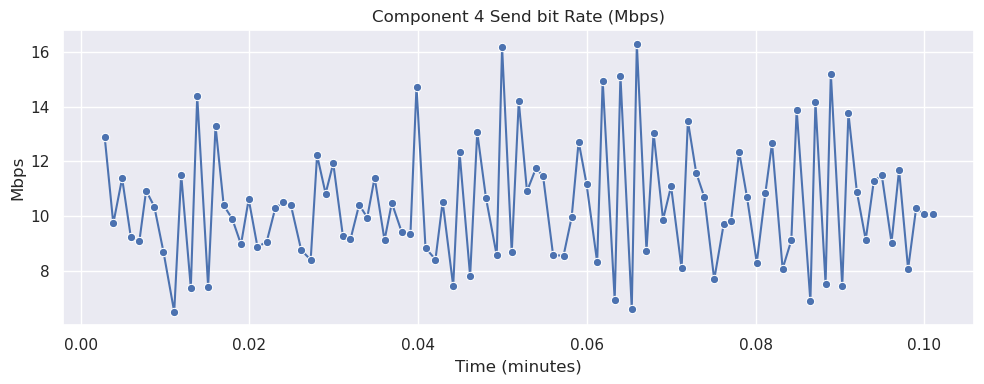

Component 5 Send Delta Statistics:
count: 98.000
mean: 10.399
std: 2.639
skew: 0.810
kurtosis: 0.616


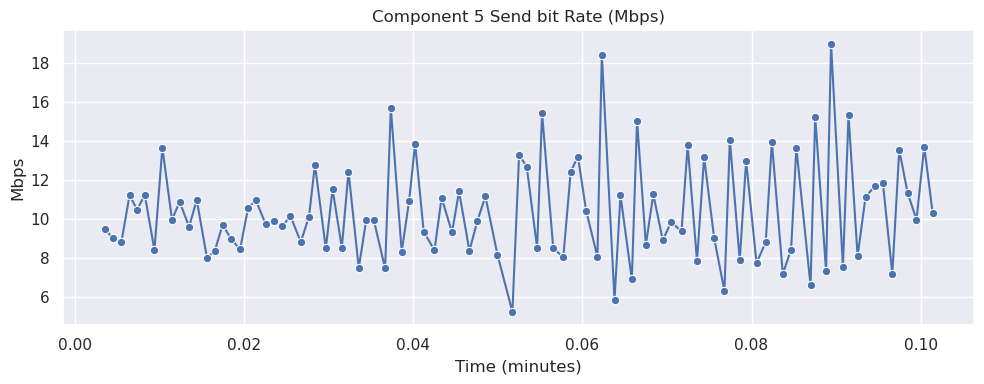

In [15]:
#Plot for Sender = component 0
for i in range(0, prm_cmpnt_cnt): #last component does not send

    sim_tm_uS = sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][1:].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == i, "snt_uS"][:-1].reset_index(drop=True))
    szs_b = sentFrms_df.loc[sentFrms_df["component"] == i, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {i} Send Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    if i == 0:
        plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    else:
        sns.lineplot(x=u_1*sim_tm_uS/60, y=btRt_Mbps, marker='o')
    plt.title(f"Component {i} Send bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Frame Rate Statistics:
count: 99.000
mean: 16.667
std: 0.000
skew: 0.238
kurtosis: 0.781


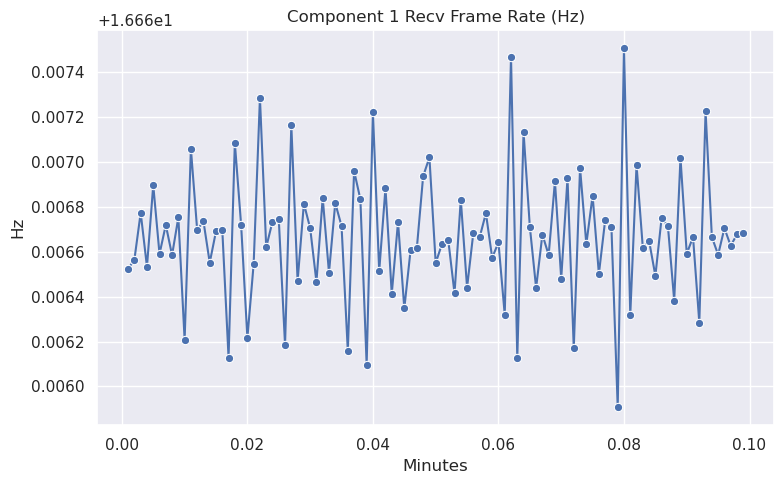

Component 2 Frame Rate Statistics:
count: 99.000
mean: 16.745
std: 1.065
skew: 0.349
kurtosis: 0.495


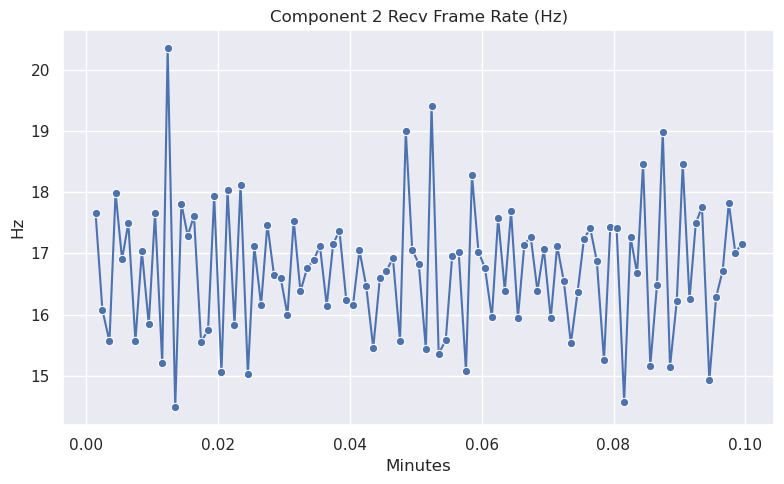

Component 3 Frame Rate Statistics:
count: 99.000
mean: 16.936
std: 2.179
skew: 0.608
kurtosis: 0.064


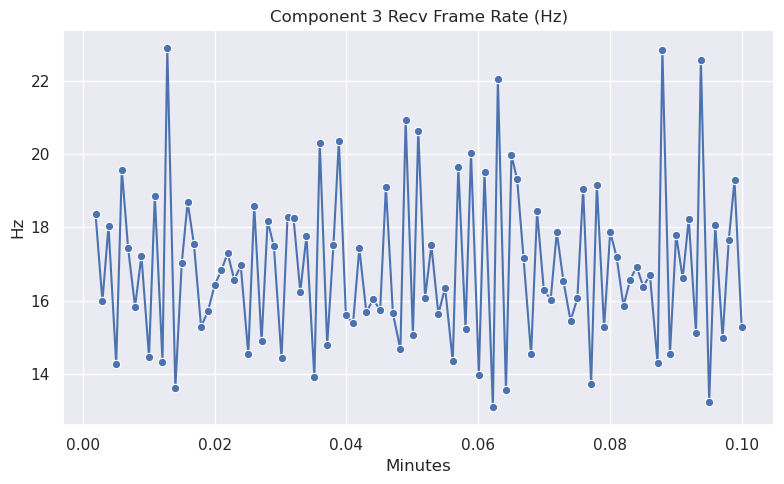

Component 4 Frame Rate Statistics:
count: 99.000
mean: 17.124
std: 2.890
skew: 0.741
kurtosis: 0.484


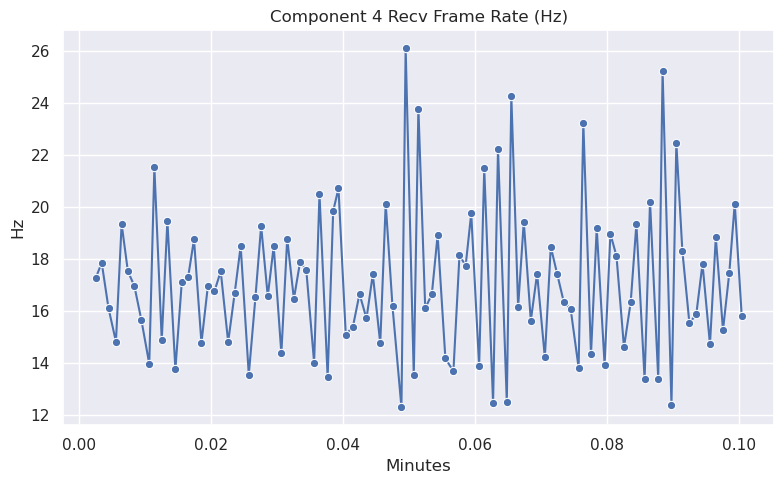

Component 5 Frame Rate Statistics:
count: 98.000
mean: 17.175
std: 3.600
skew: 0.874
kurtosis: 0.947


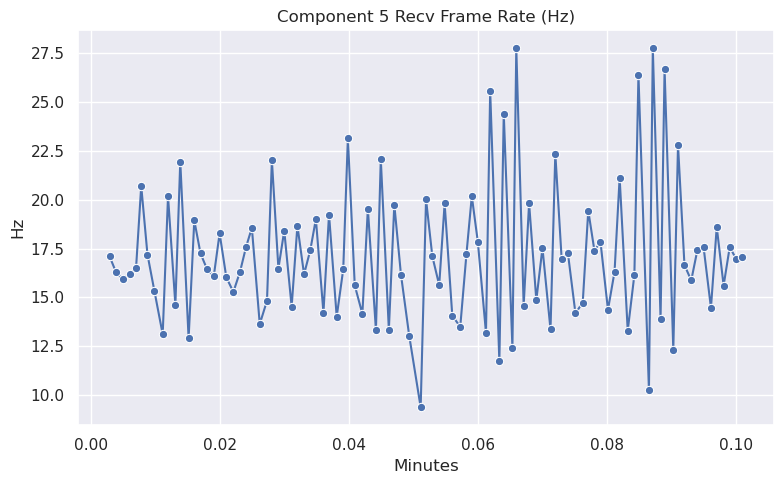

Component 6 Frame Rate Statistics:
count: 97.000
mean: 17.303
std: 4.258
skew: 0.804
kurtosis: 0.610


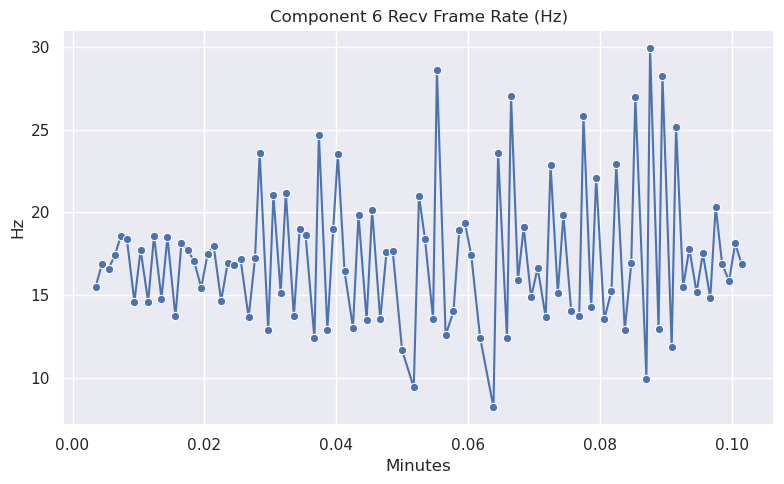

In [16]:
#Plot for Components - Recv Frame Rate
for i in range(1, prm_cmpnt_cnt + 1): ######################################################################## 1 + 1): # 
    dt_S_arr           = np.diff(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"])
    frame_rates_Hz_arr = np.array(1/dt_S_arr)

    # Display statistics
    frame_rate_stats = compute_moments(frame_rates_Hz_arr)

    print(f"Component {i} Frame Rate Statistics:")
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")

    # Plot Frame Rate
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))

    timestamps_S_arr = np.array(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:])
    window = 1
    sns.lineplot(x=timestamps_S_arr[window-1:]/60.0, y=moving_average(frame_rates_Hz_arr, n=window), marker="o")
    # plt.plot(timestamps_S_arr/60.0, frame_rates_Hz_arr, marker='o', linestyle='-')
    # plt.ylim(frame_rates_Hz_arr.min(), max(frame_rates_Hz_arr))
    plt.ticklabel_format(style='plain', axis='y')   # disable scientific/offset notation

    plt.title(f"Component {i} Recv Frame Rate (Hz)")
    plt.xlabel("Minutes")
    plt.ylabel("Hz")
    plt.tight_layout()
    plt.show()

    # # Plot
    # plt.figure(figsize=(10, 4))
    # plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    # plt.title(f"Component {i} Send bit Rate (Mbps)")
    # plt.xlabel('Time (minutes)')
    # plt.ylabel('Mbps')
    # #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


Component 1 Recv Delta Statistics:
count: 99.000
mean: 29.941
std: 3.031
skew: -0.029
kurtosis: -0.162


<Figure size 800x500 with 0 Axes>

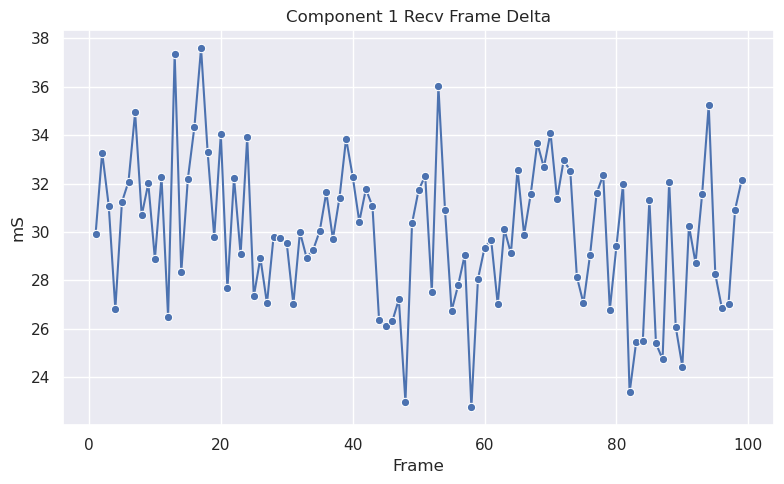

Component 2 Recv Delta Statistics:
count: 99.000
mean: 28.806
std: 5.799
skew: -0.377
kurtosis: 0.175


<Figure size 800x500 with 0 Axes>

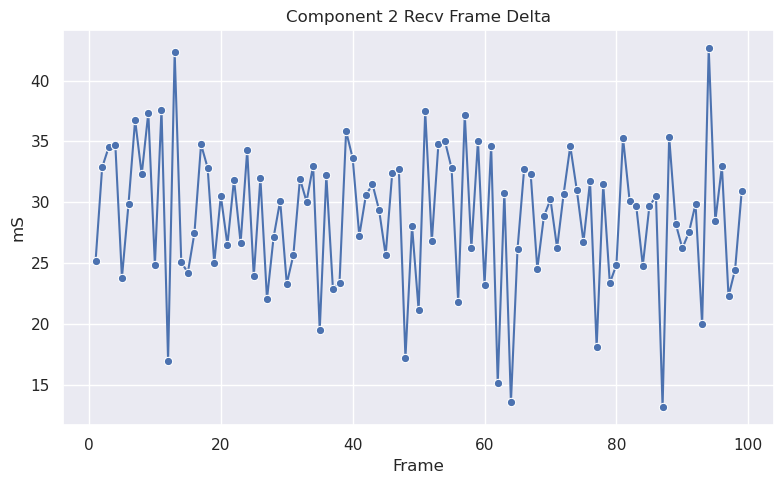

Component 3 Recv Delta Statistics:
count: 99.000
mean: 30.254
std: 8.576
skew: -0.165
kurtosis: -0.436


<Figure size 800x500 with 0 Axes>

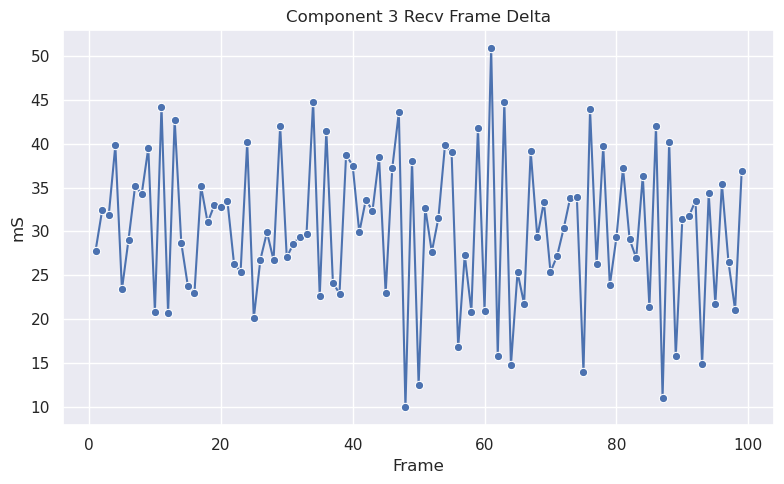

Component 4 Recv Delta Statistics:
count: 99.000
mean: 29.931
std: 10.633
skew: 0.001
kurtosis: -0.371


<Figure size 800x500 with 0 Axes>

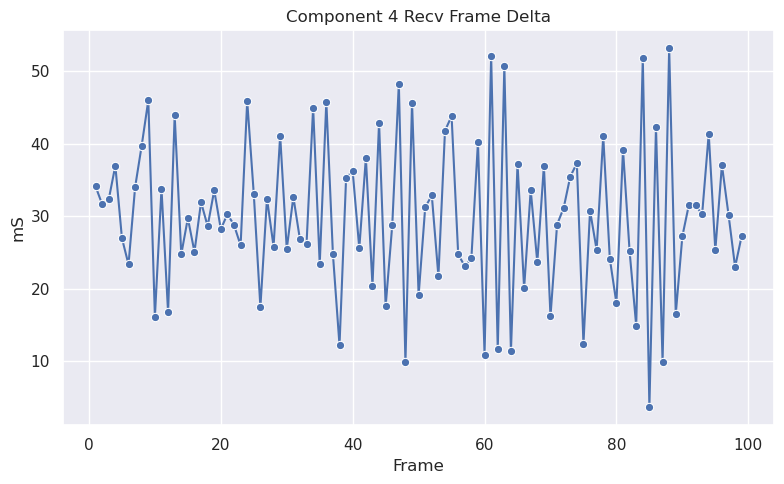

Component 5 Recv Delta Statistics:
count: 98.000
mean: 30.780
std: 12.908
skew: 0.375
kurtosis: 0.481


<Figure size 800x500 with 0 Axes>

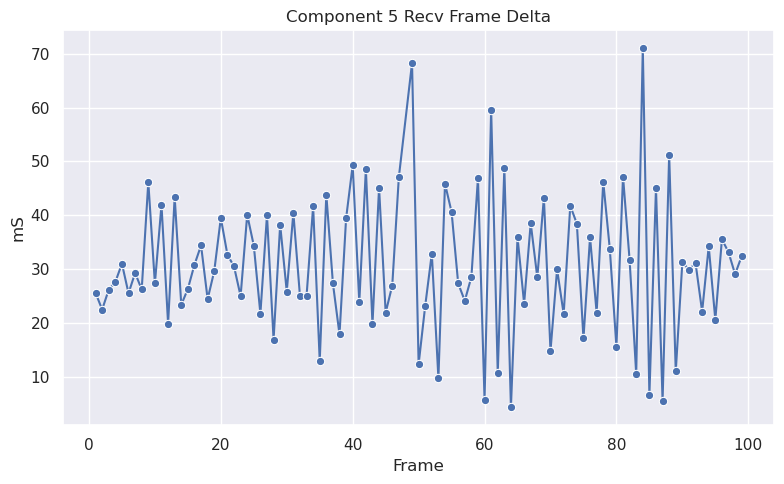

Component 6 Recv Delta Statistics:
count: 97.000
mean: 31.093
std: 14.947
skew: 0.801
kurtosis: 1.457


<Figure size 800x500 with 0 Axes>

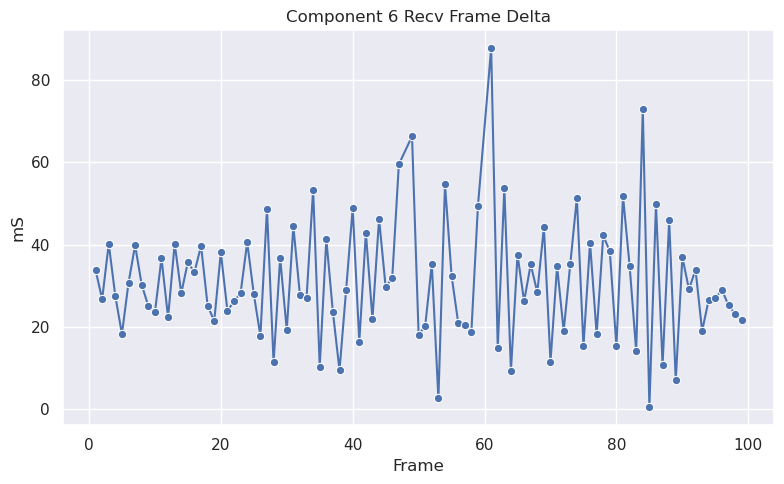

In [17]:
#Plot for Components - Recv Frame Delta Time
for i in range(1, prm_cmpnt_cnt + 1):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    rcd_uS =  prcsdFrms_df.loc[prcsdFrms_df["component"] == i,  "rcd_uS"][1:].reset_index(drop=True)
    done_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "done_uS"][:-1].reset_index(drop=True)

    # print(i)
    # print(rcd)
    # print(done)

    delta_mS = u_m*(rcd_uS - done_uS)

    # Display statistics
    delta_stats_mS = compute_moments(delta_mS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in delta_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"][1:].reset_index(drop=True), y=delta_mS , marker="o")       # line + markers
    plt.title(f"Component {i} Recv Frame Delta")
#    plt.xlabel("Minutes")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



Component 1 Recv Delta Statistics:
count: 99.000
mean: 0.008
std: 0.001
skew: 1.089
kurtosis: 0.430


<Figure size 800x500 with 0 Axes>

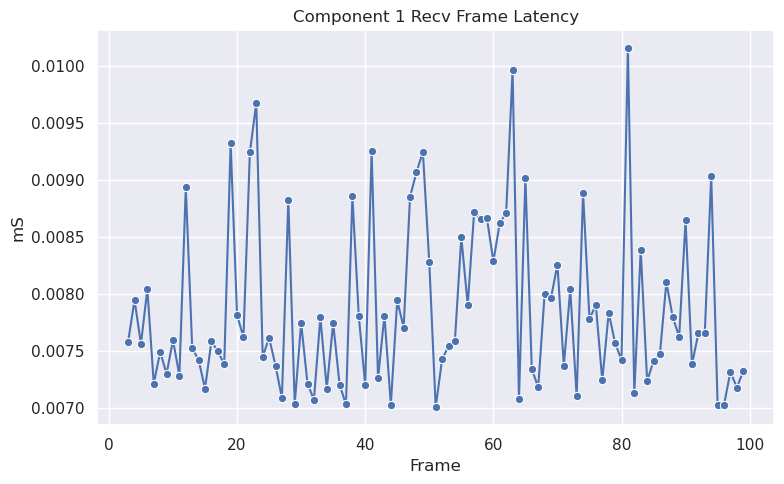

Component 2 Recv Delta Statistics:
count: 99.000
mean: 0.018
std: 0.001
skew: 0.017
kurtosis: -0.080


<Figure size 800x500 with 0 Axes>

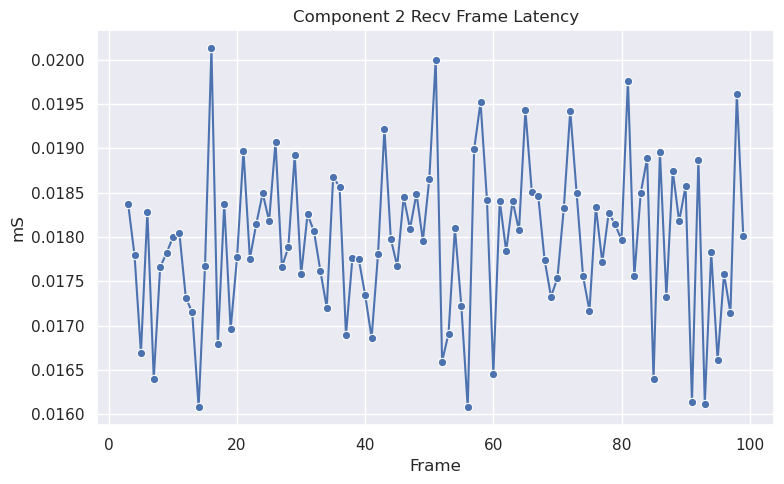

Component 3 Recv Delta Statistics:
count: 99.000
mean: 0.018
std: 0.001
skew: 0.610
kurtosis: -0.131


<Figure size 800x500 with 0 Axes>

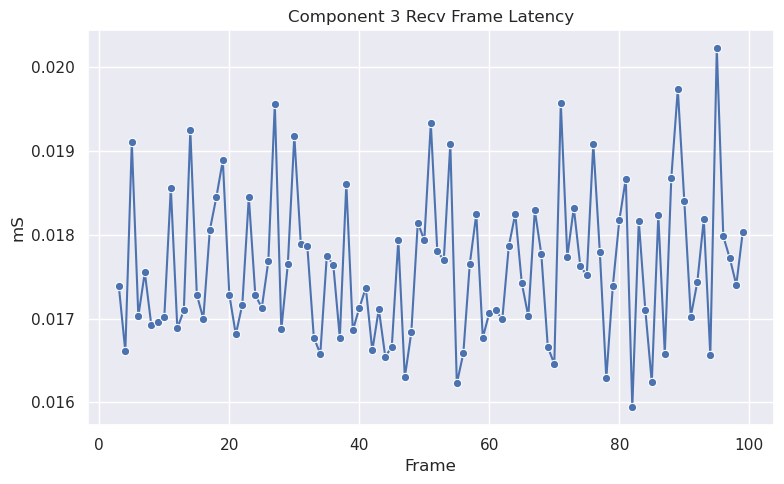

Component 4 Recv Delta Statistics:
count: 99.000
mean: 0.018
std: 0.001
skew: 1.122
kurtosis: 2.419


<Figure size 800x500 with 0 Axes>

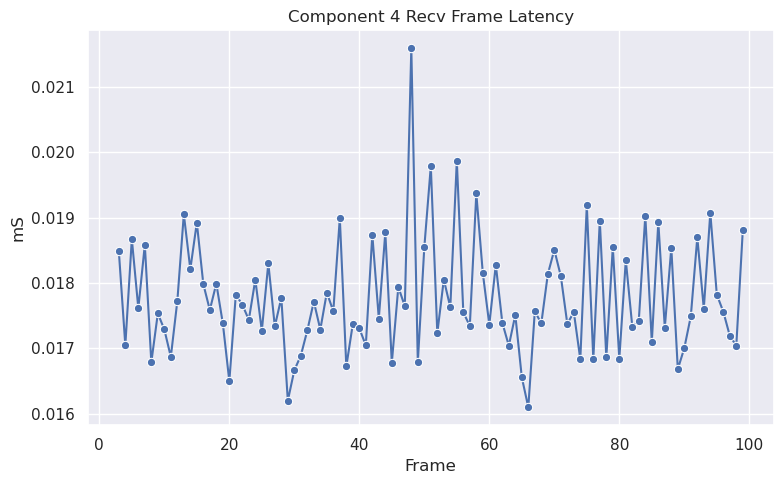

Component 5 Recv Delta Statistics:
count: 99.000
mean: 31.257
std: 31.626
skew: nan
kurtosis: nan


<Figure size 800x500 with 0 Axes>

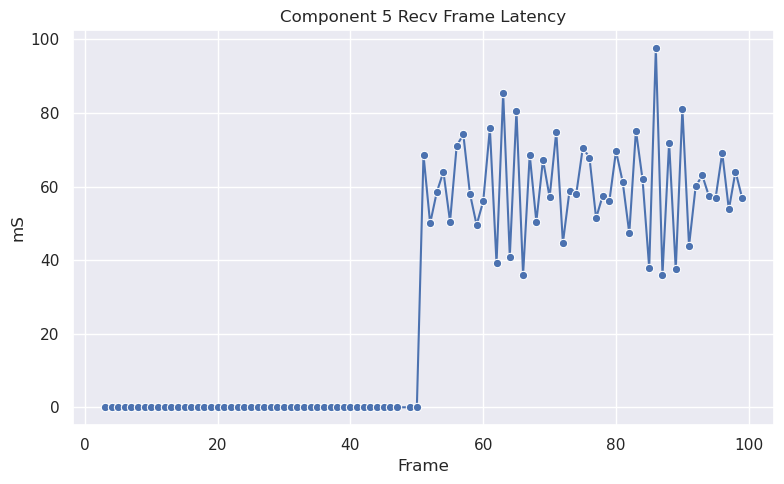

Component 6 Recv Delta Statistics:
count: 98.000
mean: 24.216
std: 31.325
skew: nan
kurtosis: nan


<Figure size 800x500 with 0 Axes>

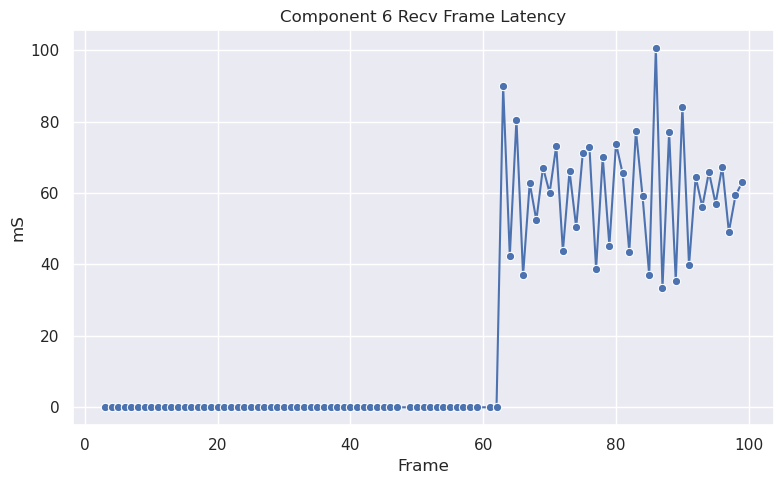

In [18]:
#Plot for Components - Recv Frame Latency

for i in range(1, prm_cmpnt_cnt + 1):

    plt.figure(figsize=(8, 5))
    # sns.lineplot(x=[u_1*float(x)/60.0 for x in done_timestamps_uS_lst[1:]], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers
    # sns.lineplot(x=df.loc[df["component"] == i, "frm_nm"][1:], y=[u_m*(recd_timestamps_uS_lst[i+1] - done_timestamps_uS_lst[i]) for i in range(len(done_timestamps_uS_lst) - 1)], marker="o")       # line + markers

    ltnc_mS = u_m*(prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"].reset_index(drop=True) - sentFrms_df.loc[sentFrms_df["component"] == i-1, "snt_uS"].reset_index(drop=True))

    # Display statistics
    ltnc_stats_mS = compute_moments(ltnc_mS[1:])

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in ltnc_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # print(diff)
    # print(df.loc[df["component"] == i, "frm_nm"][1:])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"][2:].reset_index(drop=True), y=ltnc_mS[1:] , marker="o")       # line + markers
    plt.title(f"Component {i} Recv Frame Latency")
    plt.xlabel("Frame")
    plt.ylabel("mS")
    plt.tight_layout()
    plt.show()



Component 1 Recv Delta Statistics:
count: 99.000
mean: 10.000
std: 0.000
skew: 0.238
kurtosis: 0.781


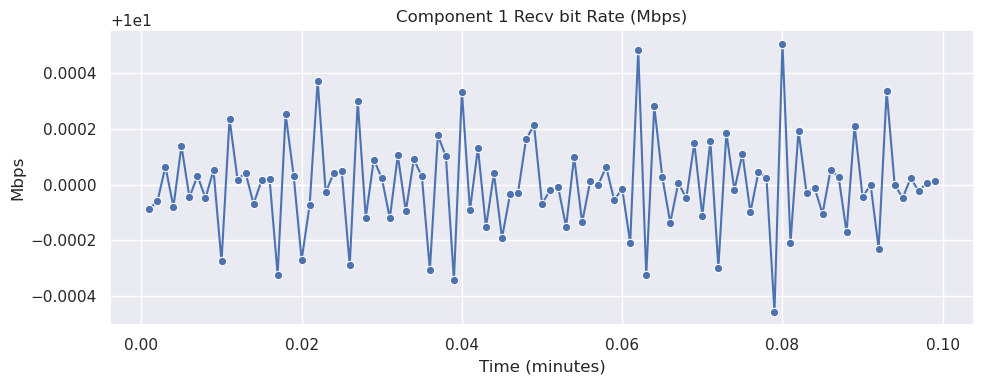

Component 2 Recv Delta Statistics:
count: 99.000
mean: 10.192
std: 1.256
skew: 0.065
kurtosis: -0.700


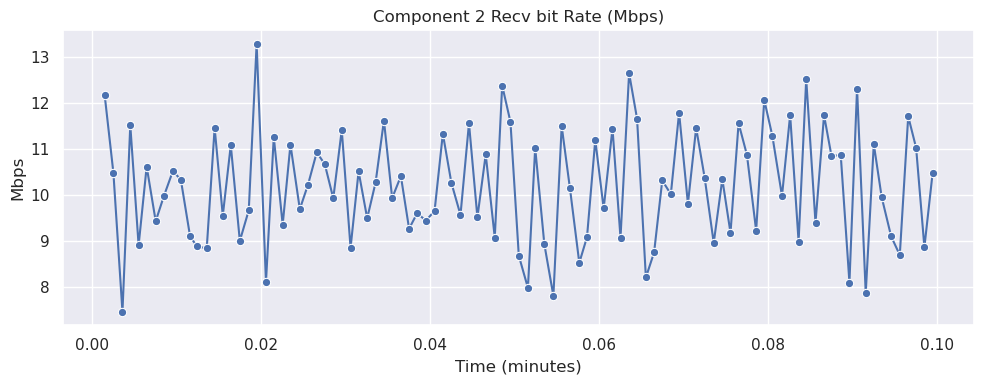

Component 3 Recv Delta Statistics:
count: 99.000
mean: 9.942
std: 1.677
skew: 0.983
kurtosis: 1.222


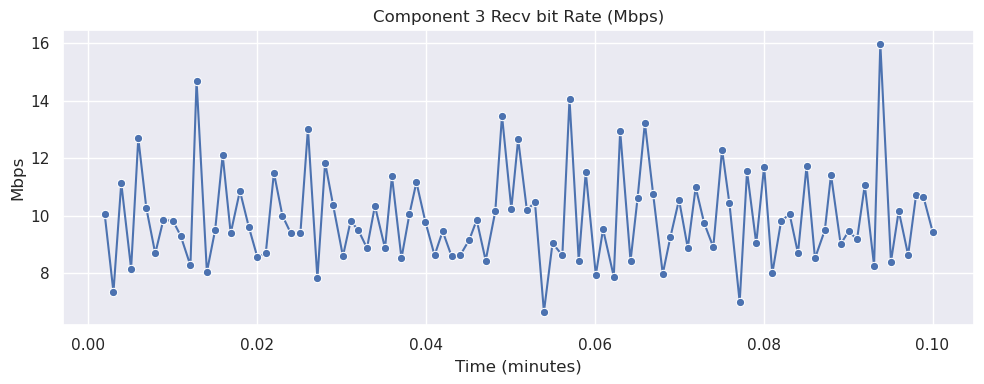

Component 4 Recv Delta Statistics:
count: 99.000
mean: 10.208
std: 1.899
skew: 0.479
kurtosis: -0.169


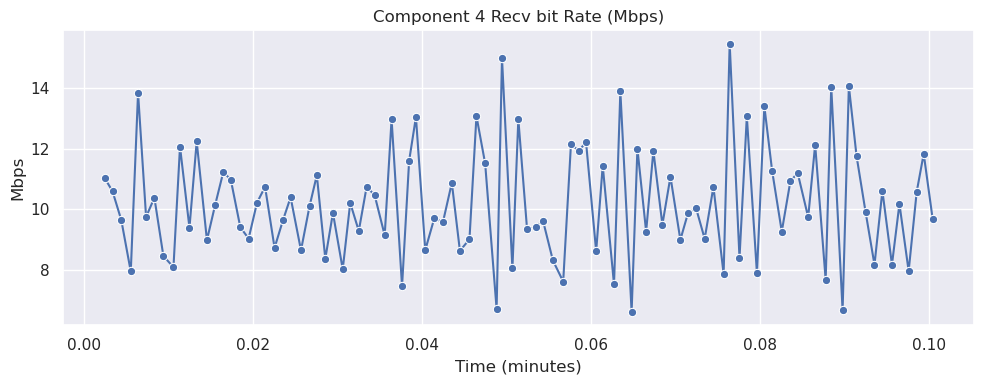

Component 5 Recv Delta Statistics:
count: 98.000
mean: 10.353
std: 2.213
skew: 0.448
kurtosis: -0.194


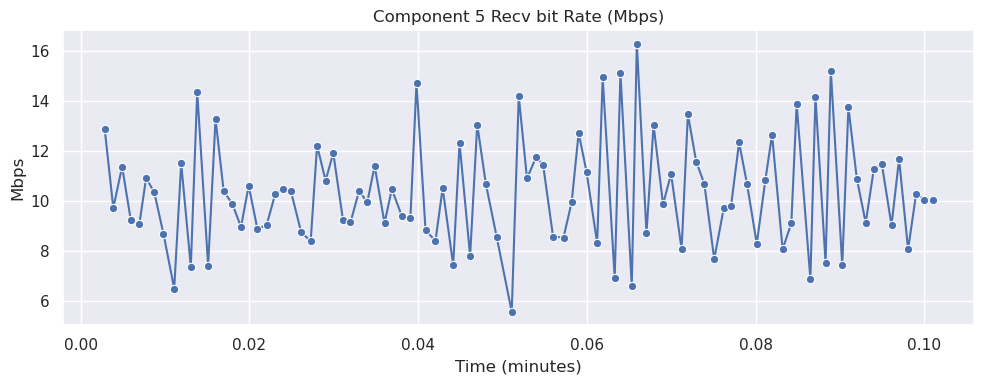

Component 6 Recv Delta Statistics:
count: 97.000
mean: 10.300
std: 2.554
skew: 0.612
kurtosis: 0.447


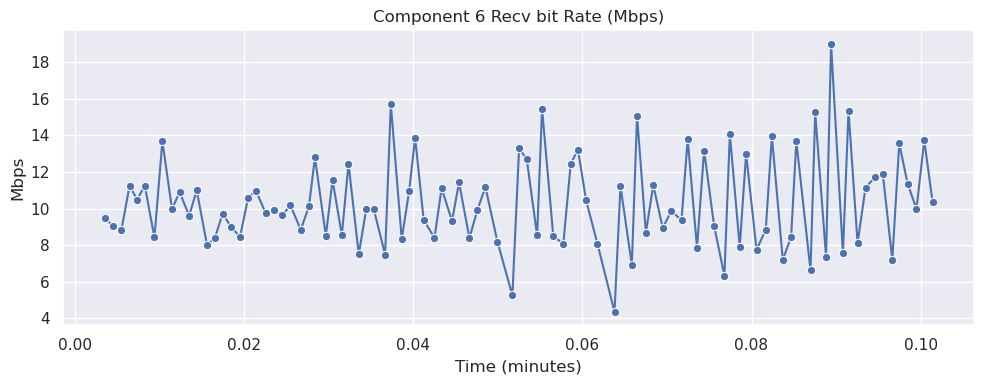

In [19]:
#Plot for Components - Recv Bit Rate
for i in range(1, prm_cmpnt_cnt + 1):

    sim_tm_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:].reset_index(drop=True)
    dts_S = u_1*(prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][1:].reset_index(drop=True) - prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"][:-1].reset_index(drop=True))
    szs_b = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_sz_b"][1:].reset_index(drop=True)

    btRt_Mbps = one_M*szs_b/dts_S
    # Display statistics
    btRt_stats_Mbps = compute_moments(btRt_Mbps)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in btRt_stats_Mbps.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    # plt.plot(u_1*sim_tm_uS/60, btRt_Mbps, marker='o', linestyle='-')
    sns.lineplot(x=u_1*sim_tm_uS/60, y=btRt_Mbps, marker='o', linestyle='-')
    plt.title(f"Component {i} Recv bit Rate (Mbps)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Mbps')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 100.000
mean: 30.000
std: 3.040
skew: 0.046
kurtosis: -0.199


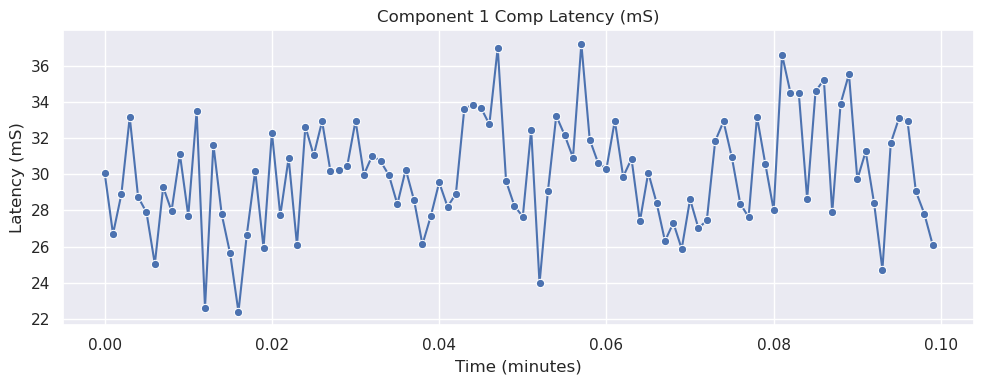

Component 2 Recv Delta Statistics:
count: 100.000
mean: 31.168
std: 4.137
skew: 0.451
kurtosis: 0.196


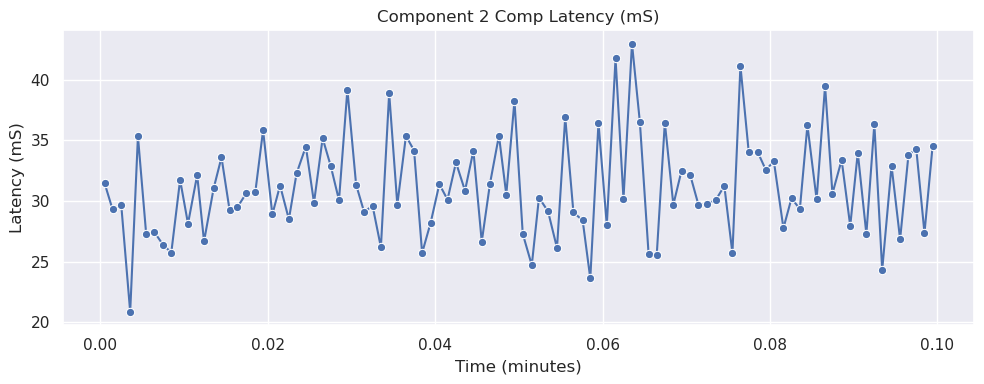

Component 3 Recv Delta Statistics:
count: 100.000
mean: 29.683
std: 4.069
skew: 0.755
kurtosis: 0.451


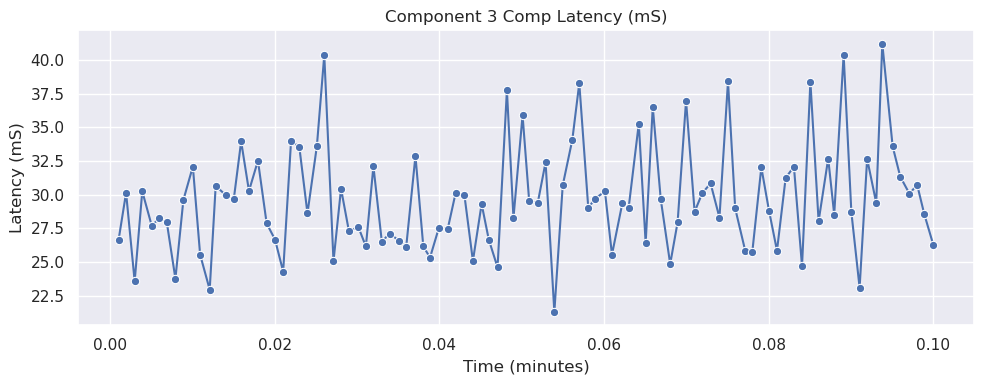

Component 4 Recv Delta Statistics:
count: 100.000
mean: 30.048
std: 4.001
skew: 0.834
kurtosis: 1.196


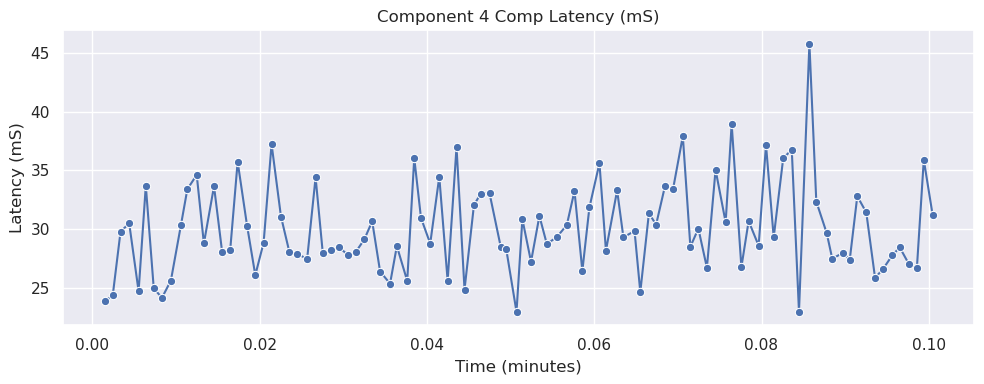

Component 5 Recv Delta Statistics:
count: 99.000
mean: 29.844
std: 4.307
skew: 0.232
kurtosis: -0.175


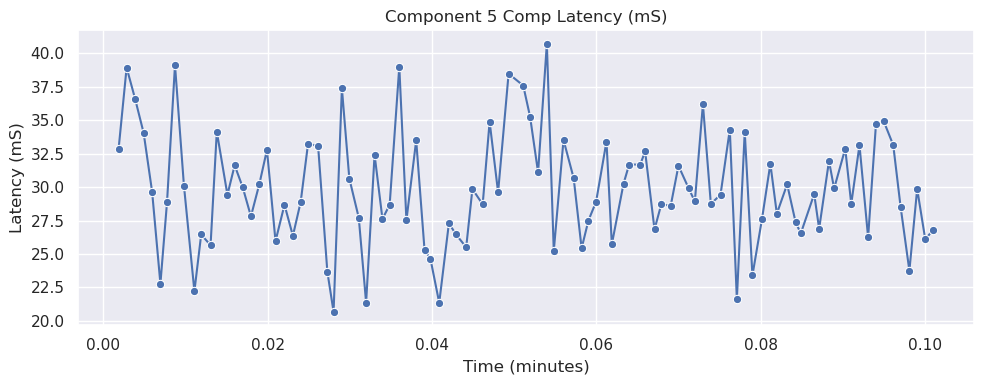

Component 6 Recv Delta Statistics:
count: 98.000
mean: 30.106
std: 4.647
skew: 0.362
kurtosis: -0.034


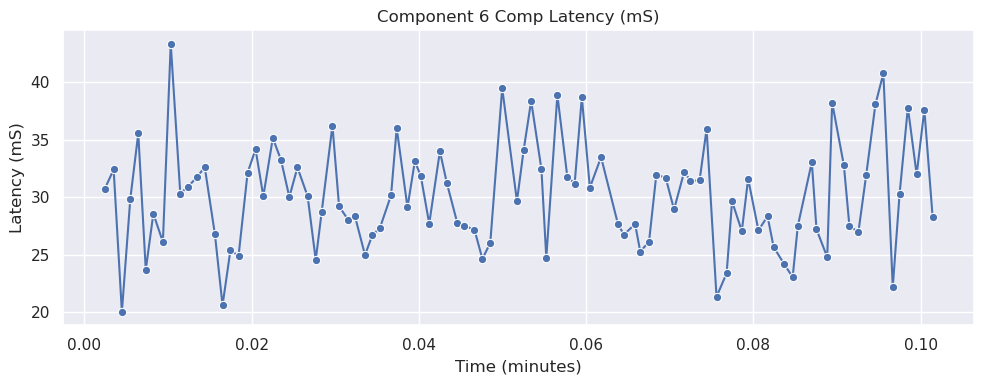

In [20]:
#Plot for Components - Comp Latency
for i in range(1, prm_cmpnt_cnt + 1):

    cmpLt_mS = u_m*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "cmp_ltnc_uS"]
    # Display statistics
    cmpLt_stats_mS = compute_moments(cmpLt_mS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in cmpLt_stats_mS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    # plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, cmpLt_mS, marker='o', linestyle='-')
    sns.lineplot(x=u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, y=cmpLt_mS, marker='o', linestyle='-')
    plt.title(f"Component {i} Comp Latency (mS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (mS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

Component 1 Recv Delta Statistics:
count: 100.000
mean: 7.846
std: 0.735
skew: 1.096
kurtosis: 0.445


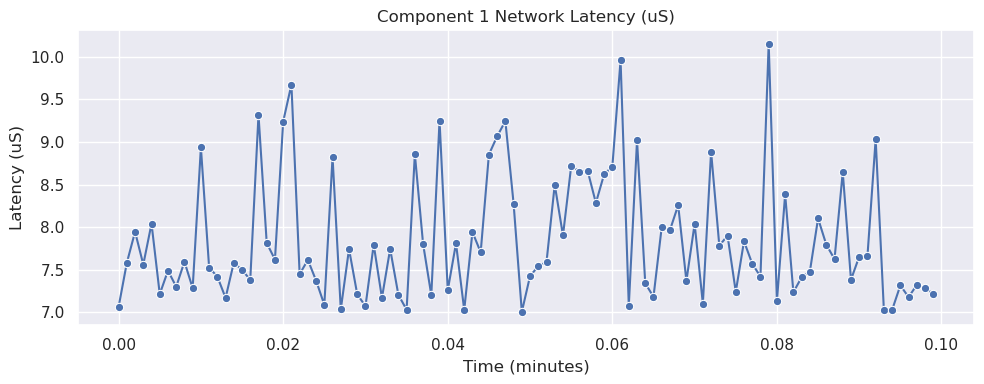

Component 2 Recv Delta Statistics:
count: 100.000
mean: 7.946
std: 0.876
skew: -0.001
kurtosis: -0.078


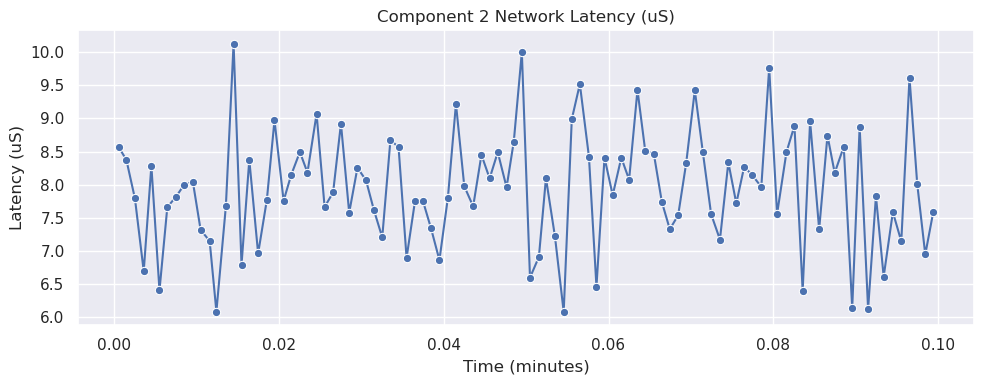

Component 3 Recv Delta Statistics:
count: 100.000
mean: 7.610
std: 0.896
skew: 0.625
kurtosis: -0.119


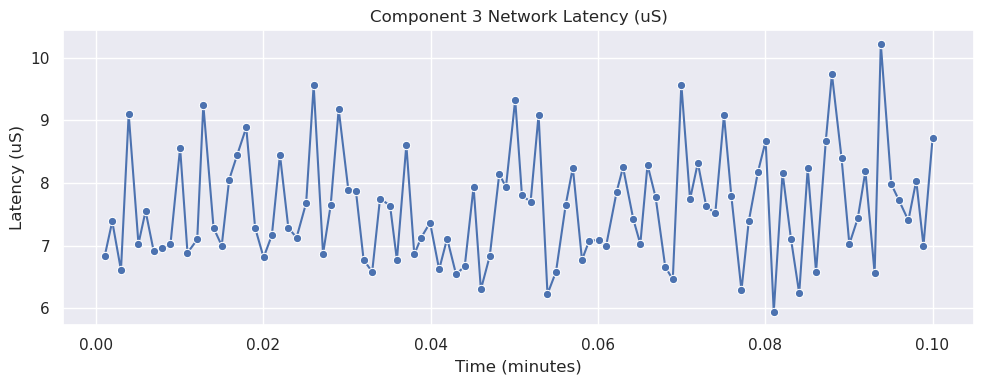

Component 4 Recv Delta Statistics:
count: 100.000
mean: 7.760
std: 0.878
skew: 1.132
kurtosis: 2.478


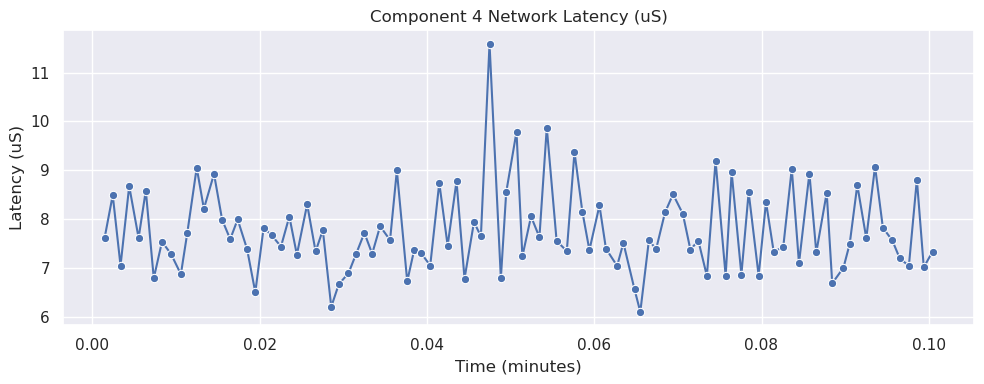

Component 5 Recv Delta Statistics:
count: 99.000
mean: 7.728
std: 0.787
skew: 0.613
kurtosis: 0.031


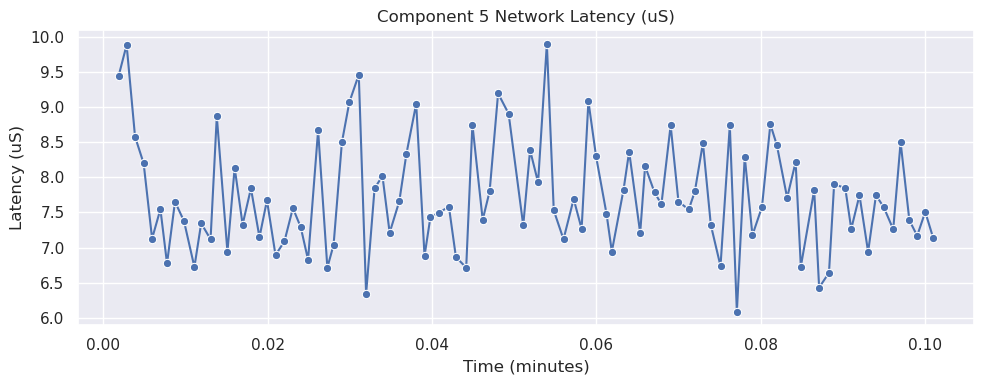

Component 6 Recv Delta Statistics:
count: 98.000
mean: 7.883
std: 0.895
skew: 0.236
kurtosis: -0.356


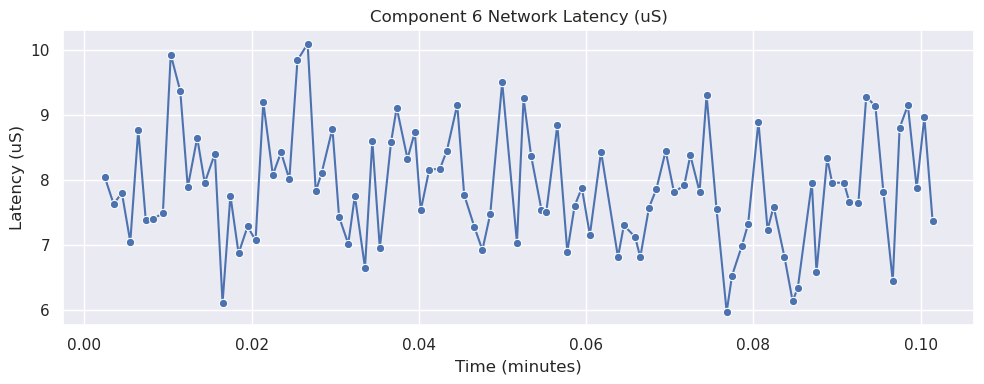

In [21]:
#Plot for Components - Network Latency
for i in range(1, prm_cmpnt_cnt + 1):

    ntwrkLt_uS = prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "ntwrk_lt_uS"]
    # Display statistics
    ntwrkLt_stats_uS = compute_moments(ntwrkLt_uS)

    print(f"Component {i} Recv Delta Statistics:")
    for k, v in ntwrkLt_stats_uS.items():
        print(f"{k}: {v:.3f}")

    # Plot
    plt.figure(figsize=(10, 4))
    # plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, ntwrkLt_uS, marker='o', linestyle='-')
    sns.lineplot(x=u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, y=ntwrkLt_uS, marker='o', linestyle='-')
    plt.title(f"Component {i} Network Latency (uS)")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (uS)')
    #plt.ylim(0, np.isfinite(recd['fps_roll'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # print(recd.tail(5))

    # recd.drop(recd.index, inplace=True)

    # print(recd.tail(5))

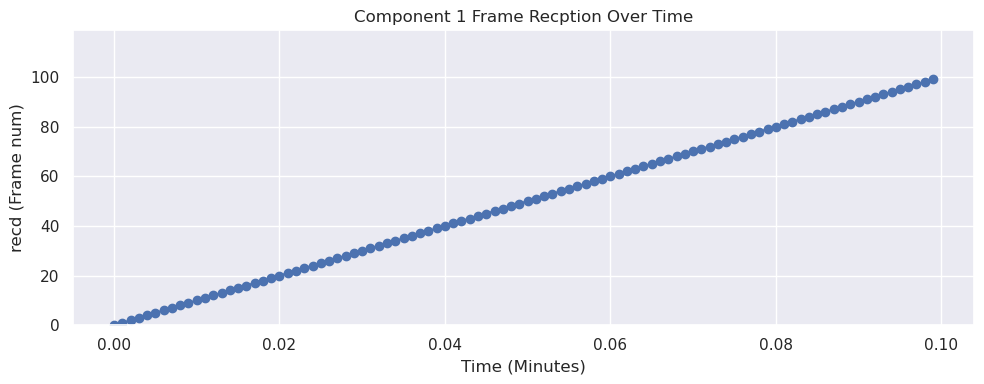

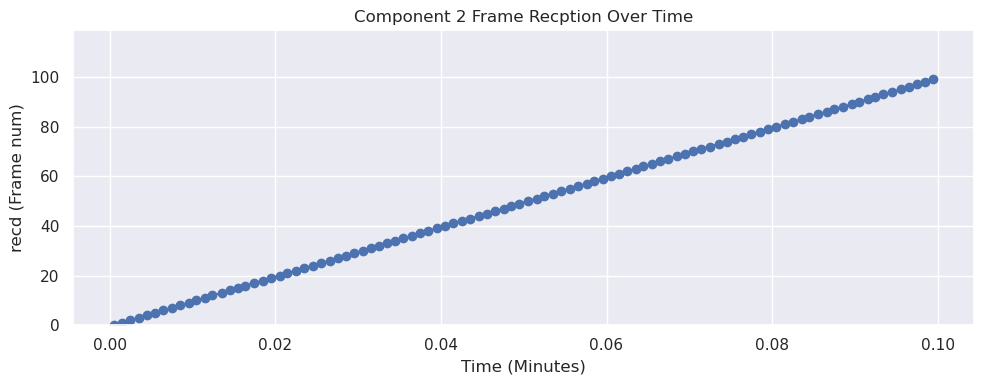

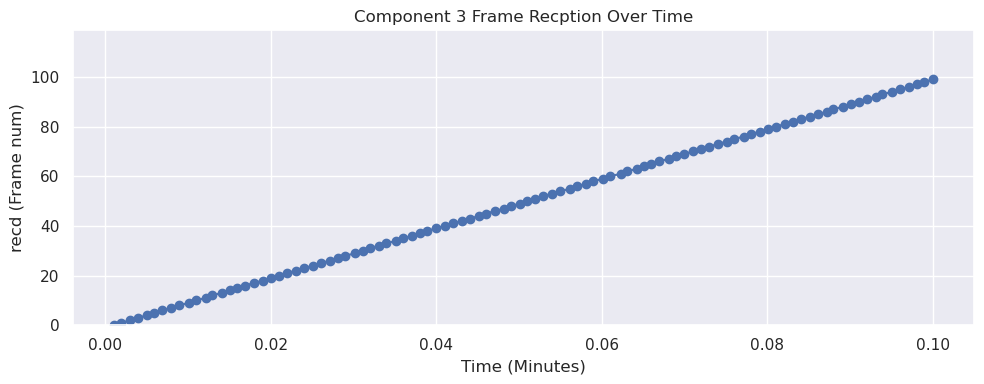

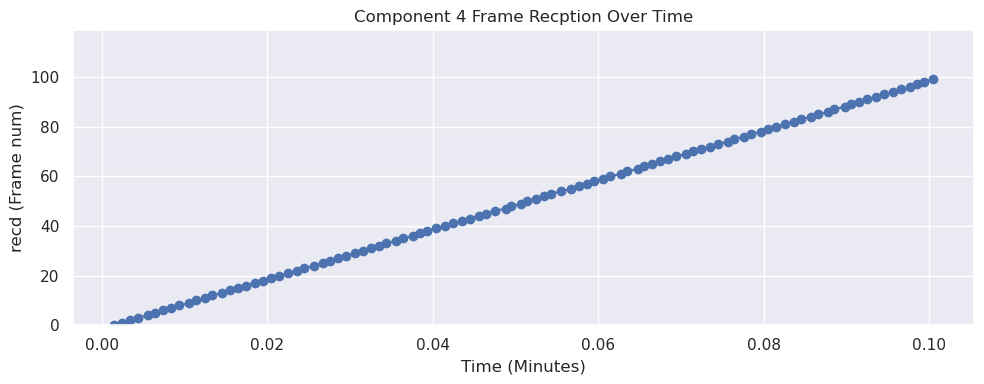

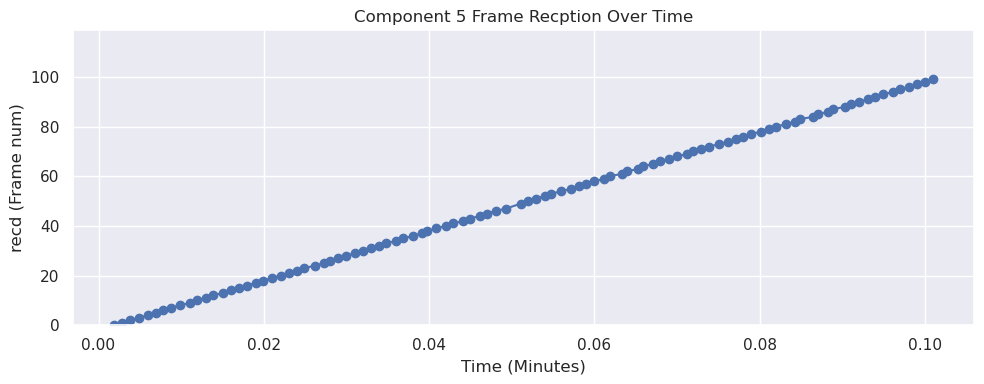

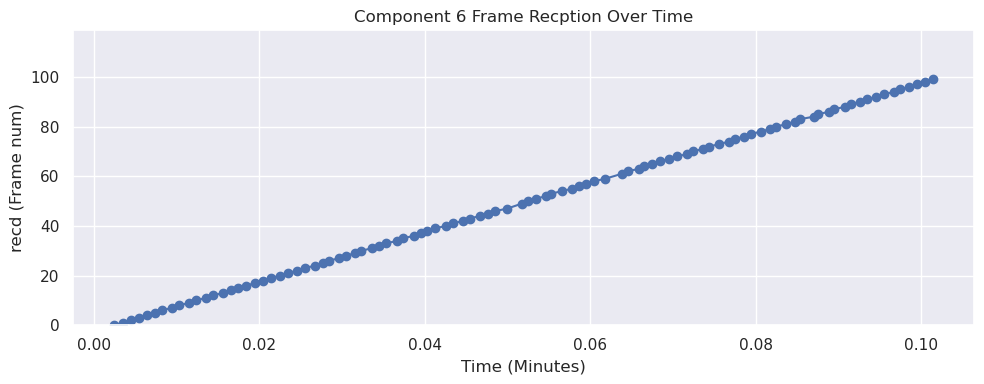

In [22]:
#Plot for Components - Recvd Frames
for i in range(1, prm_cmpnt_cnt + 1):
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    # sns.lineplot(x=u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, y=prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o')
    plt.title(f"Component {i} Frame Recption Over Time")
    plt.xlabel('Time (Minutes)')
    plt.ylabel('recd (Frame num)')
    plt.ylim(0, max(prcsdFrms_df['frm_nm']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


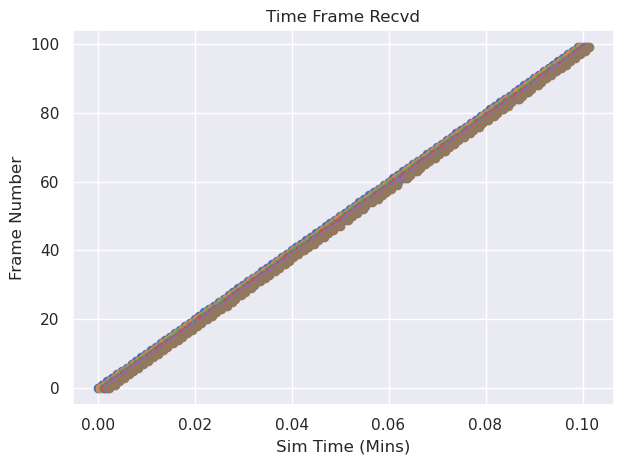

In [23]:
#Plot for Components - Recvd Frame Time
for i in range(1, prm_cmpnt_cnt + 1):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "rcd_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Sim Time (Mins)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


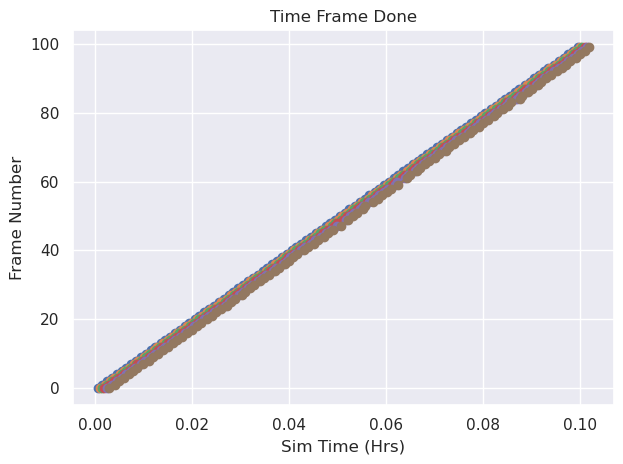

In [24]:
#Plot for Components - Frame Done
for i in range(1, prm_cmpnt_cnt + 1):
    # Plot
    plt.plot(u_1*prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "done_uS"]/60, prcsdFrms_df.loc[prcsdFrms_df["component"] == i, "frm_nm"], marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Sim Time (Hrs)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
for c in cmpnt_drp_nms:
    print(f"Number of drops for component {c}: {len(drp_sets_by_component[c])}")

Number of drops for component 5: 1
Number of drops for component 6: 1


In [26]:
drp_sets_by_component

component
5    {48}
6    {60}
Name: frm_nm, dtype: object

In [27]:
cmpnt_drp_nms

{np.int64(5), np.int64(6)}

In [28]:
prcsd_frm_sets_by_component = prcsdFrms_df.groupby("component")["frm_nm"].apply(set)
cmpnt_frn_nms = set(prcsdFrms_df["component"].unique())
for c in cmpnt_frn_nms:
    print(f"Number of processed frames for component {c}: {len(prcsd_frm_sets_by_component[c])}")

Number of processed frames for component 1: 100
Number of processed frames for component 2: 100
Number of processed frames for component 3: 100
Number of processed frames for component 4: 100
Number of processed frames for component 5: 99
Number of processed frames for component 6: 98


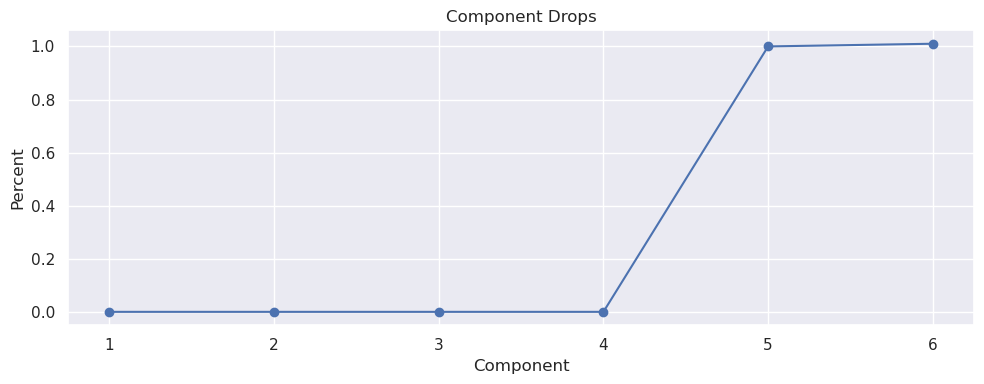

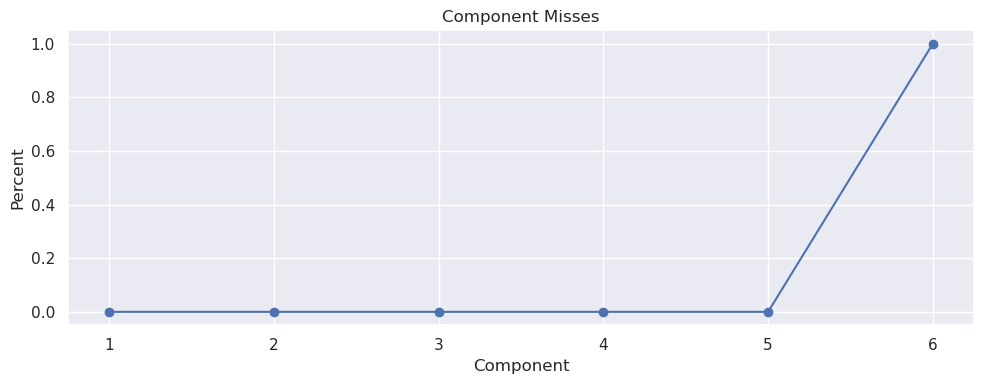

In [29]:
#Plot for Components - Dropped/Missed Frames
drpdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "drp_frctn":   pd.Series(dtype=int)
})

cmpnt_drp_nms = set(drpmsdFrms_df["component"].unique())
#dataframe record for components with no drops
for c in set(range(1,prm_cmpnt_cnt+1)) - cmpnt_drp_nms: #the set of compnents with no drops
    row = (c,0)
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)
    
#dataframe record for components with drops
drp_sets_by_component = drpmsdFrms_df.groupby("component")["frm_nm"].apply(set)
for c in cmpnt_drp_nms:
    row = (c,len(drp_sets_by_component[c])/(len(drp_sets_by_component[c]) + len(prcsd_frm_sets_by_component[c])))
    drpdFrmsFrctn_df = pd.concat([drpdFrmsFrctn_df, pd.DataFrame([row], columns=drpdFrmsFrctn_df.columns)], ignore_index=True)


# drpdFrmsFrctn_df

# Plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

x = drpdFrmsFrctn_df['component'].astype(int)
y = 100*drpdFrmsFrctn_df['drp_frctn']
max_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Drops")
ax.set_xlabel("Component")
ax.set_ylabel("Percent")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()

#Frames that components missed because they were never received
msdFrmsFrctn_df = pd.DataFrame({
    "component": pd.Series(dtype=int),
    "msd_frctn": pd.Series(dtype=int)
})

#Compnents miss frames when upstream senders do not send
#Upstrean components do not send frames they miss or drop
#The effect is cummulative for downstream components

#For each component, This equates to the number of sender frames - (number processd + the number droped (since they were not missed))

for c in range(1,prm_cmpnt_cnt+1):
    # print(f"drpdFrmsFrctn_df for component {c}: {drpdFrmsFrctn_df.loc[drpdFrmsFrctn_df["component"] == (c-1), "drp_frctn"]}")
    # row = (c,1-(len(prcsd_frm_sets_by_component[c]) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))/len(cnst_all_frm_set))
    row = (c,1-(len(set(prcsdFrms_df.loc[prcsdFrms_df["component"] == c, "frm_nm"])) + len(set(drpmsdFrms_df.loc[drpmsdFrms_df["component"] == c, "frm_nm"])))/len(cnst_all_frm_set))
    msdFrmsFrctn_df = pd.concat([msdFrmsFrctn_df, pd.DataFrame([row], columns=msdFrmsFrctn_df.columns)], ignore_index=True)

x = msdFrmsFrctn_df['component'].astype(int)
y = 100*msdFrmsFrctn_df['msd_frctn']
ax_y = np.nanmax(y) if len(y) else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, marker='o', linestyle='-')
ax.set_title("Component Misses")
ax.set_xlabel("Component")
ax.set_ylabel("Percent")
# ax.set_ylim(-0.01, max_y * 1.2)

# Force integer tick locations
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(True)
fig.tight_layout()
plt.show()
